## 0) Environment & Data

In [13]:
import warnings, os, sys, math, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [14]:
# Load data 
df = pd.read_csv("data.csv")
print(df.shape)
df.head()

(800, 19)


,Age,Height_cm,Weight_kg,Position,Training_Hours_Per_Week,Matches_Played_Past_Season,Previous_Injury_Count,Knee_Strength_Score,Hamstring_Flexibility,Reaction_Time_ms,Balance_Test_Score,Sprint_Speed_10m_s,Agility_Score,Sleep_Hours_Per_Night,Stress_Level_Score,Nutrition_Quality_Score,Warmup_Routine_Adherence,Injury_Next_Season,BMI
0,22,173,64,Midfielder,11.575308,36,1,77.460279,79.115738,284.487853,91.212476,5.874630,77.599705,8.238293,46.616415,81.472206,1,0,21.383942
1,18,170,67,Midfielder,12.275869,37,2,72.634442,82.541688,250.579249,87.294078,5.796269,94.418987,8.983737,49.368037,81.056677,1,0,23.183391
2,22,186,75,Forward,12.254896,12,2,77.064490,75.943631,269.119918,83.440688,5.731209,70.179176,7.229193,43.132808,64.877457,0,1,21.678807
3,20,172,62,Defender,9.006678,11,1,82.810232,73.878324,226.376412,87.591894,6.220212,83.473824,7.681029,51.528529,89.824744,1,0,20.957274
4,18,172,94,Midfielder,12.683668,10,2,76.772859,76.653043,229.021042,83.125161,5.385958,87.037256,6.728091,52.379718,71.569197,0,1,31.773932


## 1) Quick sanity checks

In [15]:
# Basic info
print(df.dtypes)
print("\nNull counts:\n", df.isna().sum())

# Target distribution
target_col = "Injury_Next_Season"
print("\nTarget distribution:\n", df[target_col].value_counts(normalize=True).round(3))

Age                             int64
Height_cm                       int64
Weight_kg                       int64
Position                       object
Training_Hours_Per_Week       float64
Matches_Played_Past_Season      int64
Previous_Injury_Count           int64
Knee_Strength_Score           float64
Hamstring_Flexibility         float64
Reaction_Time_ms              float64
Balance_Test_Score            float64
Sprint_Speed_10m_s            float64
Agility_Score                 float64
Sleep_Hours_Per_Night         float64
Stress_Level_Score            float64
Nutrition_Quality_Score       float64
Warmup_Routine_Adherence        int64
Injury_Next_Season              int64
BMI                           float64
dtype: object

Null counts:
 Age                           0
Height_cm                     0
Weight_kg                     0
Position                      0
Training_Hours_Per_Week       0
Matches_Played_Past_Season    0
Previous_Injury_Count         0
Knee_Strength_Score      

## 2) Feature/Target split & column types

In [16]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Age', 'Height_cm', 'Weight_kg', 'Training_Hours_Per_Week', 'Matches_Played_Past_Season', 'Previous_Injury_Count', 'Knee_Strength_Score', 'Hamstring_Flexibility', 'Reaction_Time_ms', 'Balance_Test_Score', 'Sprint_Speed_10m_s', 'Agility_Score', 'Sleep_Hours_Per_Night', 'Stress_Level_Score', 'Nutrition_Quality_Score', 'Warmup_Routine_Adherence', 'BMI']
Categorical columns: ['Position']


## 3) Preprocessing

- Numeric: impute median

- Categorical: impute most frequent + one-hot encode

In [17]:
from sklearn.preprocessing import OneHotEncoder

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop=None))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("cat", categorical_tf, categorical_cols),
    ],
    remainder="drop"
)

## 4) Train/Test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (640, 18) (640,)
Test shape: (160, 18) (160,)


## 5) Baseline Random Forest

In [19]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",   
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", rf)
])

pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6) Evaluation (Test set)

In [20]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

Accuracy : 0.9563
Precision: 0.9620  Recall: 0.9500  F1: 0.9560
ROC AUC  : 0.9949

              precision    recall  f1-score   support

           0     0.9506    0.9625    0.9565        80
           1     0.9620    0.9500    0.9560        80

    accuracy                         0.9563       160
   macro avg     0.9563    0.9563    0.9562       160
weighted avg     0.9563    0.9563    0.9562       160



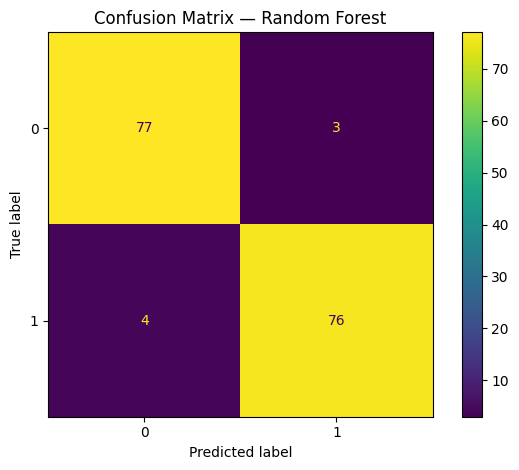

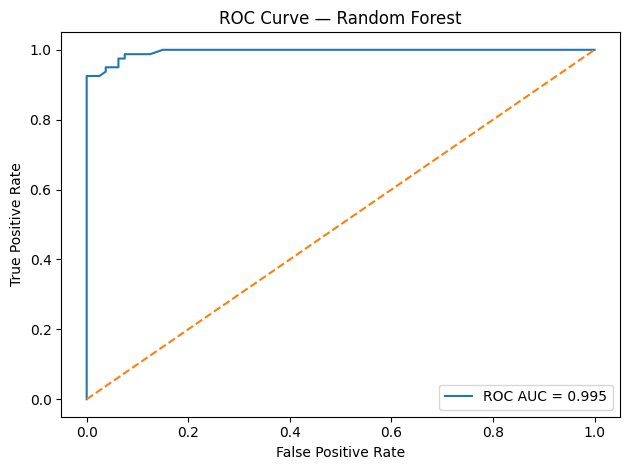

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=pipe.named_steps["rf"].classes_)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

## 7) Cross-validation (5-fold)

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("CV ROC AUC:", np.round(cv_scores, 4))
print("CV ROC AUC mean ± std:", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV ROC AUC: [0.9921 0.9823 0.9895 0.981  0.9859]
CV ROC AUC mean ± std: 0.9862 ± 0.0042


## 8) Feature Importance

We use the baseline Random Forest model to compute feature importances.  

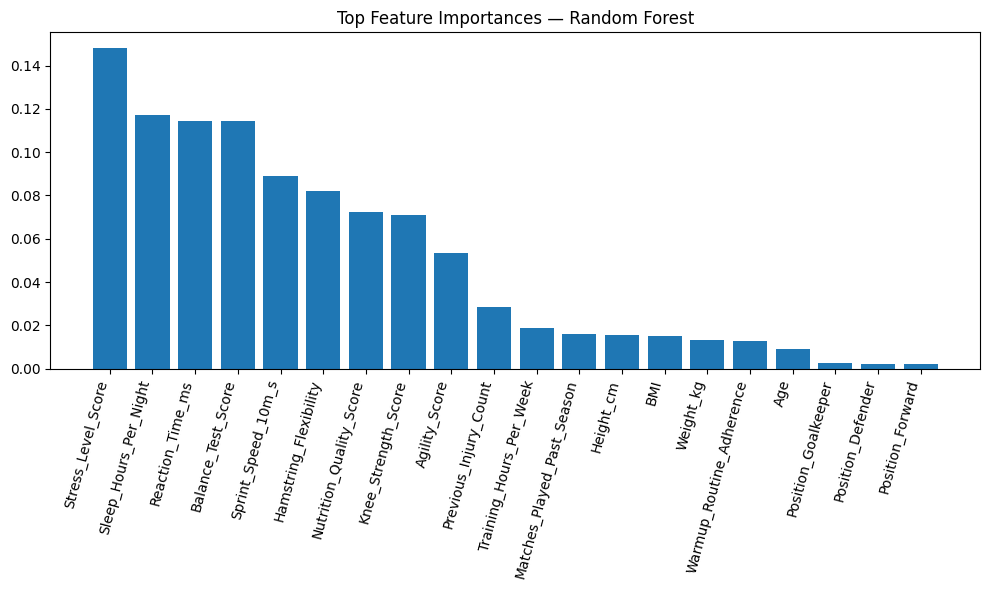

,feature,importance
0,Stress_Level_Score,0.147926
1,Sleep_Hours_Per_Night,0.117175
2,Reaction_Time_ms,0.114265
3,Balance_Test_Score,0.114197
4,Sprint_Speed_10m_s,0.089203
5,Hamstring_Flexibility,0.082097
6,Nutrition_Quality_Score,0.072146
7,Knee_Strength_Score,0.071193
8,Agility_Score,0.053506
9,Previous_Injury_Count,0.028584


In [23]:
# Get transformed feature names from the preprocessor
def get_feature_names(preprocessor, num_cols, cat_cols):
    fn = []
    # numeric names
    fn.extend(num_cols)
    # categorical one-hot names
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
    fn.extend(cat_names)
    return fn

# Use the baseline Random Forest model
model_to_explain = pipe

# Extract feature importances from the RF
rf_step = model_to_explain.named_steps["rf"]
feat_names = get_feature_names(model_to_explain.named_steps["prep"], numeric_cols, categorical_cols)
importances = rf_step.feature_importances_

# Sort and plot
order = np.argsort(importances)[::-1]
top_k = 20  # show top 20
plt.figure(figsize=(10,6))
plt.bar(range(top_k), importances[order][:top_k], align="center")
plt.xticks(range(top_k), [feat_names[i] for i in order[:top_k]], rotation=75, ha="right")
plt.title("Top Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

# Also print a tidy table
feat_table = pd.DataFrame({"feature": [feat_names[i] for i in order],
                           "importance": importances[order]})
feat_table.head(20)

## 9) Visualizing a Single Tree from the Random Forest

Random Forest consists of many decision trees, which are ensembled together.  

To better understand how the model makes predictions, we can visualize one individual tree.

Here we show an example tree from the forest (restricted to a depth of 3 for readability).  

This helps illustrate the split criteria and decision paths, although the overall model is much more complex.


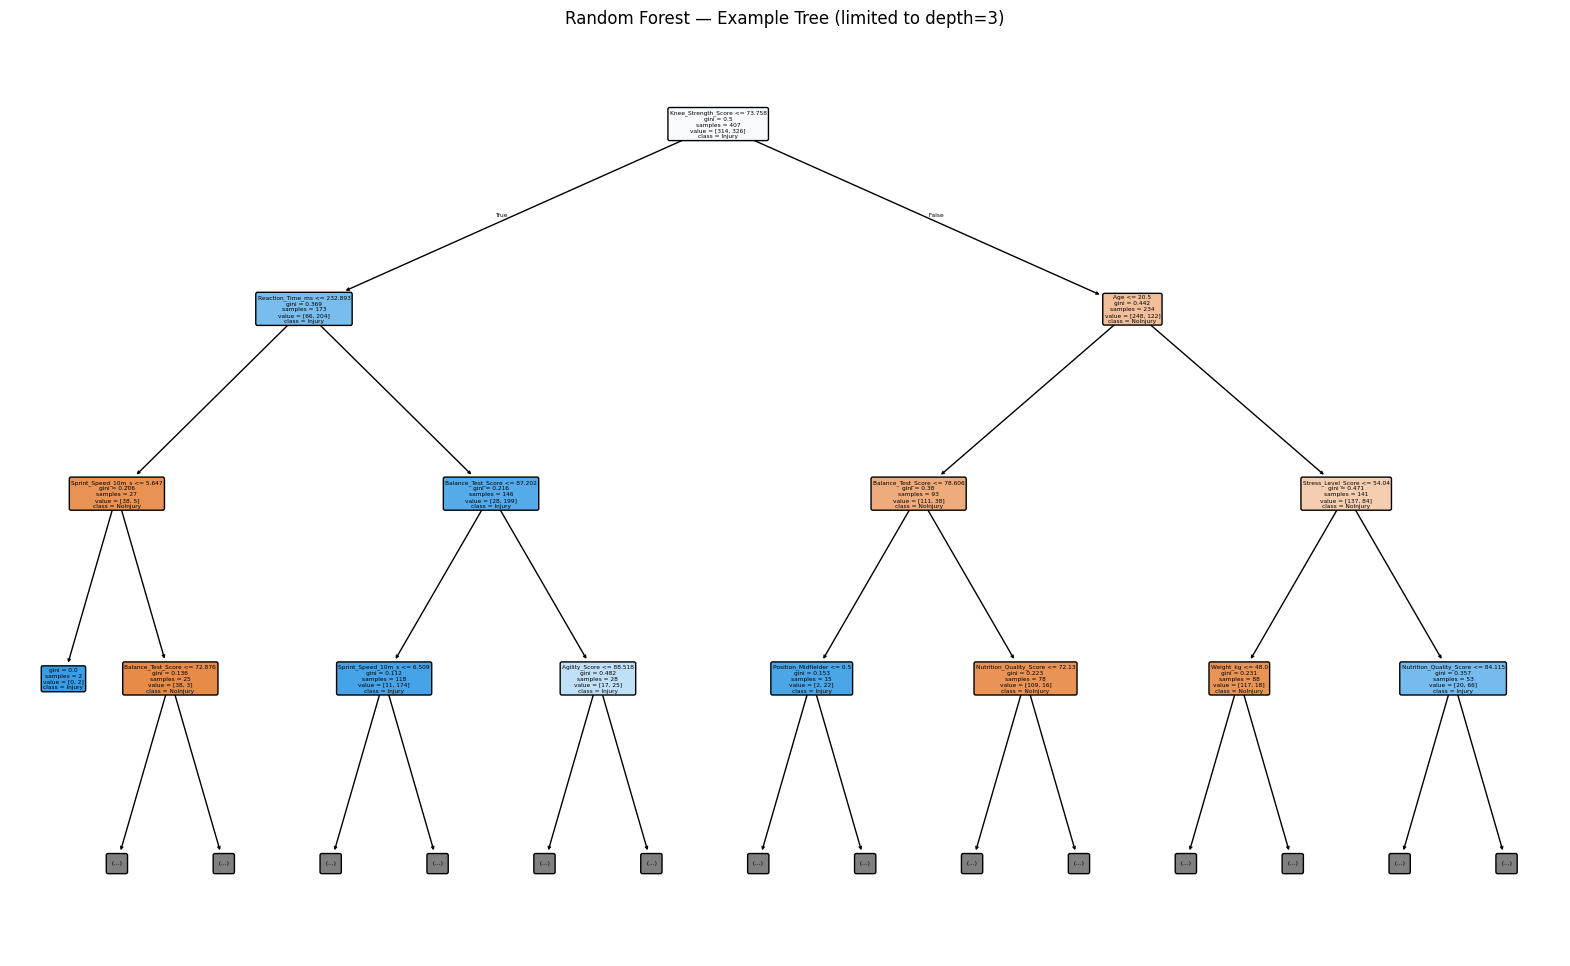

In [ ]:
# Choose one tree from the forest 
rf_model = pipe.named_steps["rf"]
estimator = rf_model.estimators_[0]

# Get feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols):
    fn = list(num_cols)
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    fn.extend(ohe.get_feature_names_out(cat_cols).tolist())
    return fn

feature_names = get_feature_names(pipe.named_steps["prep"], numeric_cols, categorical_cols)

# Plot tree (limit depth for readability)
plt.figure(figsize=(20, 12))
tree.plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=["NoInjury","Injury"],
    filled=True,
    rounded=True,
    impurity=True,
    max_depth=3  
)
plt.title("Random Forest — Example Tree (limited to depth=3)")
plt.show()